# Loading Plate Models & Plotting Static Coastlines

This tutorial shows how to:

- Load a plate model (built-in & custom)
- Reconstruct features to a past geological time
- Plot static continents/coastlines 

Let us set up our packages:

In [4]:
import gplately
from gplately import pygplates
import glob, os
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from plate_model_manager import PlateModelManager

## Load a Plate Model

We use gplately to generate a plate reconstruction model using data from "A Global Plate Model Including Lithospheric Deformation Along Major Rifts and Orogens Since the Triassic" by Müller et al. (2019). (Source: https://www.earthbyte.org/muller-et-al-2019-deforming-plate-reconstruction-and-seafloor-age-grids-tectonics/). 


We demonstrate **two ways** to load plate model files:

### From GPlately's ``Plate Model Manager``

We use Gplately's `PlateModelManager` to download necessary plate reconstruction files from supported plate models. For more information on how to use the Plate Model Manager, check out [``Plate Model Manager README``](https://github.com/michaelchin/plate-model-manager/blob/main/README.md).

In [3]:
# Create a Plate Model Manager
pm_manager = PlateModelManager()

# Load model data & download it into 'plate-model-repo'
try:
    muller2022_model = pm_manager.get_model("Muller2022", data_dir="../../data/plate-model-repo")
except Exception as e:
    print(f"Error loading model: {e}")

# Fetch components of the loaded model
rotation_model_2022 = muller2022_model.get_rotation_model()
topology_features_2022 = muller2022_model.get_topologies()
static_polygons_2022 = muller2022_model.get_static_polygons()

### From a Local File

The following works with your local plate model directory, assuming it follows the expected structure (i.e., .rot for rotations, .gpml for topologies, and a .shp file for static polygons). We use `glob` and `os` libraries to locate rotation files, topology feature files, and static polygon files from a directory(s) on your computer. We then use these file path strings to generate the necessary `<pygplates.RotationModel>`, `<pygplates.FeatureCollection>` and `<pygplates.FeatureCollection>` objects.

In [6]:
# Replace this with the path to your own plate model folder
input_directory = "../../data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/"

# Locate rotation files and set up the RotationModel object
rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model_2019 = pygplates.RotationModel(rotation_filenames)

# Locate topology feature files and set up a FeatureCollection object 
topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
topology_features_2019 = pygplates.FeatureCollection()

for topology_filename in topology_filenames:
    # Omit files with the string "Inactive" in the filepath
    if "Inactive" not in topology_filename:
        topology_features_2019.add(pygplates.FeatureCollection(topology_filename))
    else:
        topology_filenames.remove(topology_filename)

# Path to static polygon shapefile (Update with your own path!)
static_polygon_file = input_directory+"StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2019_v1.shp"
static_polygons_2019 = pygplates.FeatureCollection(static_polygon_file)

## Create a Plate Reconstruction Object

Once we have our rotation model, topology features and static polygons, we can supply them to the `PlateReconstruction` object to construct the plate motion model.

In [7]:
model = gplately.PlateReconstruction(rotation_model_2019, topology_features_2019, static_polygons_2019)

## Reconstruct Geological Features

The plate motion model we created can be used to generate plate reconstructions through geological time. Let's reconstruct subduction zones and mid-ocean ridges to 150 Ma.

In [8]:
time = 150 #Ma
subduction_data = model.tessellate_subduction_zones(time)
ridge_data = model.tessellate_mid_ocean_ridges(time)

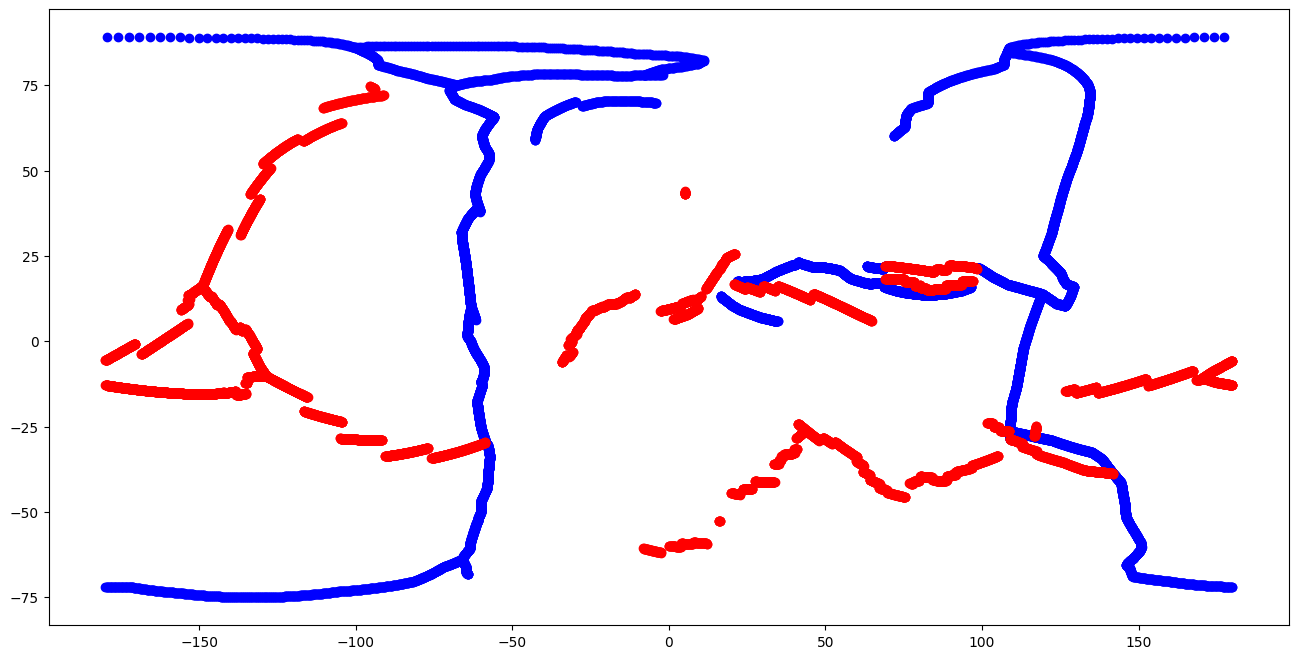

In [9]:
# Plot ridges and trenches at 150 Ma
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
ax1.scatter(subduction_data[:,0], # longitude
            subduction_data[:,1], # latitude
            color='blue')
ax1.scatter(ridge_data[:,0], # longitude
            ridge_data[:,1], # latitude
            color='red')

plt.show()

## Plotting Coastlines

The following cell of code loads and visualizes static coastline data from a shapefile using `GeoPandas` and `Matplotlib`:

<Figure size 1000x700 with 0 Axes>

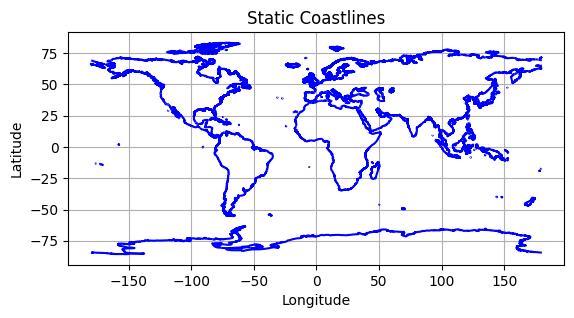

In [10]:
# Load the shapefile containing coastlines
# Update with your shapefile path
shapefile_path = "../../data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/StaticGeometries/Coastlines_AREPS/Coastlines_USGS_MedRes_AREPS_polyline.shp"
coastline_data = gpd.read_file(shapefile_path)

# Plot the coastline data
plt.figure(figsize=(10, 7))
coastline_data.plot(color='blue')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Static Coastlines')

# Show plot
plt.grid(True)
plt.show()
